# 说明
这个代码是第二天写的，么有注意到不是昨天改过的那一个版本，但是效果还好。

In [1]:
# import everything here...
%load_ext autoreload
%autoreload 2
from RL_utils import *
%matplotlib inline

In [5]:
# create env
import gym
env = gym.make("CartPole-v0")
config = Config(learning_rate=0.001, DBM=False) # 使用默认配置
if config.DBM:
    config.print_cfg()
    env = gym.make("CartPole-v1",render_mode="human")
set_seed(config)

e:\anaconda\envs\llama_factory\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [3]:
# network construction
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if config.DBM:
    print("using device:",device)
env_cfg = Env_Config(obdim=env.observation_space.shape[0],acdim=env.action_space.n)
if config.DBM:
    env_cfg.print_cfg()
epsilon = Epsilon(original_val=0.1, min_val=0.1, liner_decay=1/2000)
monte = MonteCarlo(env_config=env_cfg,config=config,device = device)
monte.model.load_state_dict(torch.load(r"2model_trained/MonteCarlo_episode1000.pth"))

using device: cuda
obdim: 4
acdim: 2


<All keys matched successfully>

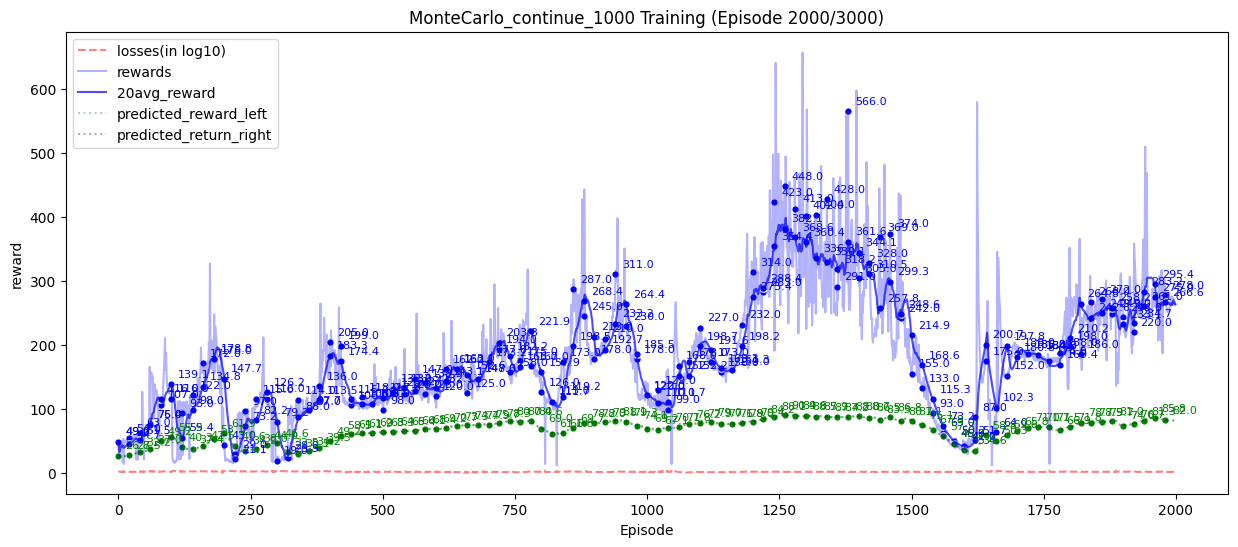

: 

In [ ]:
log = defaultdict(list)
for episode_num in range(1000, config.max_episode):
    episode_reward_list = [] # 一个episode的各个步的reward
    episode_state_list = []
    episode_action_list = []
    state, _ = env.reset(seed = config.seed)
    done = False        
    log['predicted_return_left'].append(monte.model(torch.tensor(state).to(device=device))[0].item())
    log['predicted_return_right'].append(monte.model(torch.tensor(state).to(device=device))[1].item())
    while not done:
        # 首先保存predicted_return
        action = select_action(state=state, env = env, model = monte.model, epsilon = epsilon, config=config,device=device, update_epsilon=True)
        next_state, reward, done, _, info = env.step(action=action)
        if done:
            reward = 0
        episode_reward_list.append(reward)
        episode_state_list.append(state)
        episode_action_list.append(action)
        if config.DBM:
            print_(reward)
            print_(state)
        state = next_state
    loss = monte.update(episode_reward_list=episode_reward_list,episode_state_list=episode_state_list,episode_action_list=episode_action_list)
    log["total_reward"].append(sum(episode_reward_list))
    log["total_loss"].append(np.log10(loss))
    log["20avg_reward"].append(np.mean(log["total_reward"][-20:]))
    # draw in ipynb
    draw_in_ipynb(x_s=[None,None,None,None,None],y_s=[log["total_loss"],log["total_reward"],log["20avg_reward"],log['predicted_return_left'],log['predicted_return_right']],alpha_s=[0.5,0.3,0.7,0.3,0.3],label_s=["losses(in log10)","rewards","20avg_reward",'predicted_reward_left','predicted_return_right'],mark_s=["r--",'b-',"b-","g:",'k:'],subject="MonteCarlo_continue_1000",config=config)
    if episode_num % 50 == 0:
        save_model(model=monte.model,filename=f"MonteCarlo_episode{episode_num}.pth")

In [9]:
# 效果如何还是要测试一下
env = gym.make("CartPole-v1") # no render here
test_num = 10
for episode_num in range(0,3000,50):
    episode_return_list = []
    monte.model.load_state_dict(torch.load(f"2model_trained/MonteCarlo_episode{episode_num}.pth"))
    for _ in range(test_num):
        state, _ = env.reset() # no specific seed
        done = False
        total_reward = 0
        while not done:
            action = select_action(state,env,monte.model,epsilon=Epsilon(original_val=0.1,min_val=0.1),config=config,device=device,update_epsilon=False)
            next_state, reward, done, truncated, info = env.step(action)
            total_reward += reward
            state = next_state
        episode_return_list.append(total_reward)
    print(f"Episode {episode_num}, Total Reward: {episode_return_list}, Average Reward: {np.mean(episode_return_list)}")

Episode 0, Total Reward: [9.0, 9.0, 10.0, 9.0, 10.0, 9.0, 12.0, 8.0, 9.0, 10.0], Average Reward: 9.5
Episode 50, Total Reward: [14.0, 11.0, 10.0, 11.0, 8.0, 10.0, 11.0, 12.0, 12.0, 15.0], Average Reward: 11.4
Episode 100, Total Reward: [14.0, 15.0, 11.0, 10.0, 12.0, 13.0, 10.0, 13.0, 14.0, 12.0], Average Reward: 12.4
Episode 150, Total Reward: [20.0, 14.0, 22.0, 16.0, 20.0, 21.0, 17.0, 13.0, 22.0, 19.0], Average Reward: 18.4
Episode 200, Total Reward: [19.0, 17.0, 19.0, 22.0, 23.0, 23.0, 22.0, 19.0, 20.0, 15.0], Average Reward: 19.9
Episode 250, Total Reward: [21.0, 19.0, 29.0, 20.0, 47.0, 26.0, 30.0, 13.0, 22.0, 15.0], Average Reward: 24.2
Episode 300, Total Reward: [17.0, 18.0, 15.0, 54.0, 13.0, 43.0, 46.0, 43.0, 19.0, 21.0], Average Reward: 28.9
Episode 350, Total Reward: [122.0, 128.0, 116.0, 121.0, 119.0, 113.0, 108.0, 132.0, 125.0, 125.0], Average Reward: 120.9
Episode 400, Total Reward: [13.0, 15.0, 14.0, 17.0, 10.0, 11.0, 16.0, 13.0, 12.0, 14.0], Average Reward: 13.5
Episode 45